# Modular CerberusTS Experimentation

First we make sure we are in the base working directory (this is probably not necessary if using the package):

Google Colab notebooks come with most of the packages we need, but we need to upgrade pandas and install accelerate.

Then we import the necessary CerberusTS modules.

In [1]:
import torch
# Check if CUDA is available
if torch.cuda.is_available():
    # Print the number of available CUDA devices
    print(f"Number of CUDA devices available: {torch.cuda.device_count()}")

    # Print each CUDA device
    for i in range(torch.cuda.device_count()):
        print(f"CUDA Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available.")

Number of CUDA devices available: 1
CUDA Device 0: NVIDIA GeForce GTX 1650 with Max-Q Design


In [2]:
from cerberus_ts import CerberusConfig
CerberusConfig.set_masked_norm_zero = True
CerberusConfig.processor_type = 'flatten'
CerberusConfig.foresight_residual = False

c:\Users\johnm\AppData\Local\pypoetry\Cache\virtualenvs\cerberus-ts-abOSmZJQ-py3.12\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from cerberus_ts import Cerberus, train_cerberus
from cerberus_ts import Foresight, train_foresight
from cerberus_ts import TimeseriesDataPreparer, ResponseGenerator

import pandas as pd

Here we have the ability to do some custom configuration:

## Dataset Loading

Next we need a Pandas Dataframe of some wide-formatted mutlivariate timeseries data. Here we will use the Jena Climate Data found here: https://www.kaggle.com/datasets/mnassrib/jena-climate

In [4]:
df = pd.read_csv(r"../data/jena_climate_2009_2016.csv",
                parse_dates=['Date Time'],
                index_col=['Date Time'])
df.index = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')
# For these tests we will just use a small slice of the dataset
df = df.iloc[:5000,:]

## User Argument Specification
There are a number of different arguments that can be provided to Cerberus, shown below:

In [5]:
# What ratio of data needs to be available for the various call, response, and context windows to use that timestamp?
thresholds = {
    'call': 1,
    'response': 1,
    'context_0': 1,
    'context_1': 1,
    'context_2': 1
}

# How big should the call, context(s), and response windows be?
sizes = {
    'call': 24,
    'response': 8,
    'context_0': 24,
    'context_1': 12,
    'context_2': 6
}

# What timestep should each head use?
window_timesteps = {
    'call': '10T',
    'response': '10T',
    'context_0': '1H',
    'context_1': '2H',
    'context_2': '6H'
}

# Which columns should be used for each head?
feature_indexes = {
    'call': range(0,14),
    'response': [0, 1, 4],
    'context_0': range(0,14),
    'context_1': range(0,14),
    'context_2': range(0,14)
}

## Prepare Dataset

We will use CerberusTS's TimeseriesDataPreparer class to create Torch dataloaders for all our different heads, scaled, downsampled, and coil-normalized for easy Cerberus use.

In [6]:
# Initialize the preparer
preparer = TimeseriesDataPreparer(df, sizes, thresholds, feature_indexes, window_timesteps, train_len = 20_000, feature_range = (0, 1), batch_size = 100)

# Prepare the data
preparer.prepare_data()

C:\Users\johnm\Documents\GitHub\cerberusPy\cerberus_ts\utils\data_preparation.py:31: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  mean_df = df.resample(window).mean()
C:\Users\johnm\Documents\GitHub\cerberusPy\cerberus_ts\utils\data_preparation.py:34: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  max_timestamps = df.iloc[:,1].resample(window).apply(lambda x: x.index.max())
C:\Users\johnm\Documents\GitHub\cerberusPy\cerberus_ts\utils\data_preparation.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  mean_df = df.resample(window).mean()
C:\Users\johnm\Documents\GitHub\cerberusPy\cerberus_ts\utils\data_preparation.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  max_timestamps = df.iloc[:,1].resample(window).apply(lambda x: x.index.max())


In [7]:
iterator = iter(preparer.dataloaders)
batch = next(iterator)
batch[0].device

device(type='cuda', index=0)

## CerberusTS Training (No Foresight)

In [8]:
cerberus_noforesight = Cerberus(sizes=sizes,
                 feature_indexes=feature_indexes,
                 d_neck = 128  ,
                 head_layers=["conv","conv"],
                 body_layer_sizes = [128, 64, 32, 12],
                 dropout_rate = 0.0,
                 out_channels = 64,
                 last_known_loc = 2 )
                 

In [9]:
# Prepare data for the model
calls_batch = batch[0]
responses_batch = batch[1]
last_knowns_batch = batch[2]
y_batch = batch[3]

# unmasked is on index 4, everything after that is contexts
contexts_batch = batch[5:]

model = cerberus_noforesight.to("cuda")
model.eval()
outputs = model(calls_batch, contexts_batch, responses_batch, last_knowns_batch)

print(sum(sum(sum(calls_batch.isnan()))))
print(sum(sum(sum(responses_batch.isnan()))))
print(sum(sum(last_knowns_batch.isnan())))
print(sum(sum(y_batch.isnan())))
print(sum(sum(sum(contexts_batch[0].isnan()))))
print(sum(sum(sum(contexts_batch[1].isnan()))))
print(sum(sum(sum(contexts_batch[2].isnan()))))

print(outputs.shape)

tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
torch.Size([100, 6])


In [10]:
cerberus_noforesight = train_cerberus(cerberus_noforesight, preparer.dataloaders, num_epochs = 60)

Epoch [1/60], Loss: 4.5382772896118695e-05
Epoch [2/60], Loss: 3.878439723848715e-05
Epoch [3/60], Loss: 3.4037922478091784e-05
Epoch [4/60], Loss: 3.202701779628114e-05
Epoch [5/60], Loss: 3.063638180719863e-05
Epoch [6/60], Loss: 2.9546913310696254e-05
Epoch [7/60], Loss: 2.8182067107991316e-05
Epoch [8/60], Loss: 2.6955813527820283e-05
Epoch [9/60], Loss: 2.5501133723082604e-05
Epoch [10/60], Loss: 2.43429325564648e-05
Epoch [11/60], Loss: 2.298504089594644e-05
Epoch [12/60], Loss: 2.178440237912582e-05
Epoch [13/60], Loss: 2.0135497807132196e-05
Epoch [14/60], Loss: 1.8933602286779206e-05
Epoch [15/60], Loss: 1.7721701638038213e-05
Epoch [16/60], Loss: 1.673374687015894e-05
Epoch [17/60], Loss: 1.556205634642538e-05
Epoch [18/60], Loss: 1.4905606039974373e-05
Epoch [19/60], Loss: 1.385564985412202e-05
Epoch [20/60], Loss: 1.3050954876234755e-05
Epoch [21/60], Loss: 1.22250809590696e-05
Epoch [22/60], Loss: 1.1555684845916403e-05
Epoch [23/60], Loss: 1.0999836033533939e-05
Epoch [24

## Results Review

CerberusTS has some built in functionality for generating responses as well as visualizing the results.

### Normalized Response Review

In [11]:
preparer.conserved_subgroups['response']

{'p (mbar)': 'p (mbar)_pair',
 'T (degC)': 'T (degC)_pair',
 'rh (%)': 'rh (%)_pair'}

In [12]:
df = pd.read_csv(r"../data/jena_climate_2009_2016.csv",
                parse_dates=['Date Time'],
                index_col=['Date Time'])
df.index = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')
# For these tests we will just use a small slice of the dataset
df = df.iloc[:10000,:]

# Initialize the preparer
preparer2 = TimeseriesDataPreparer(df, sizes, thresholds, feature_indexes, window_timesteps, train_len = 20_000, feature_range = (0, 1), batch_size = 100)

# Prepare the data
preparer2.prepare_data()

C:\Users\johnm\Documents\GitHub\cerberusPy\cerberus_ts\utils\data_preparation.py:31: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  mean_df = df.resample(window).mean()
C:\Users\johnm\Documents\GitHub\cerberusPy\cerberus_ts\utils\data_preparation.py:34: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  max_timestamps = df.iloc[:,1].resample(window).apply(lambda x: x.index.max())
C:\Users\johnm\Documents\GitHub\cerberusPy\cerberus_ts\utils\data_preparation.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  mean_df = df.resample(window).mean()
C:\Users\johnm\Documents\GitHub\cerberusPy\cerberus_ts\utils\data_preparation.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  max_timestamps = df.iloc[:,1].resample(window).apply(lambda x: x.index.max())


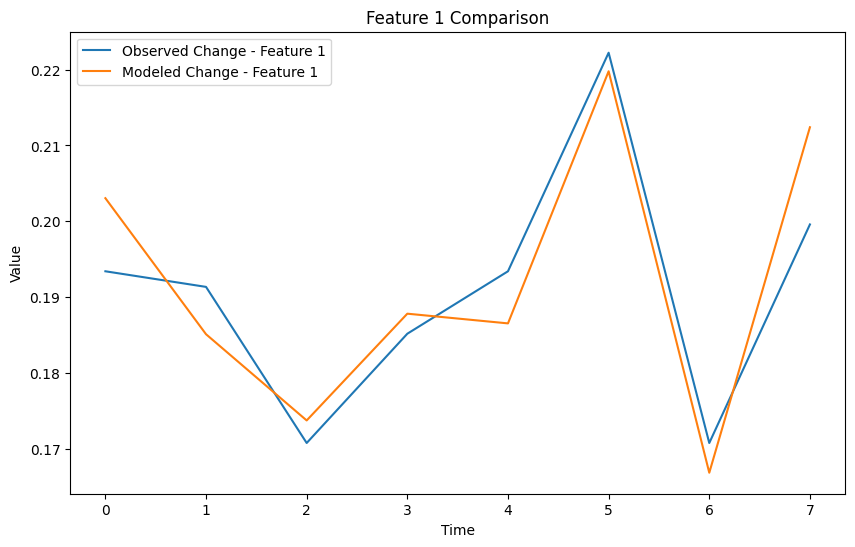

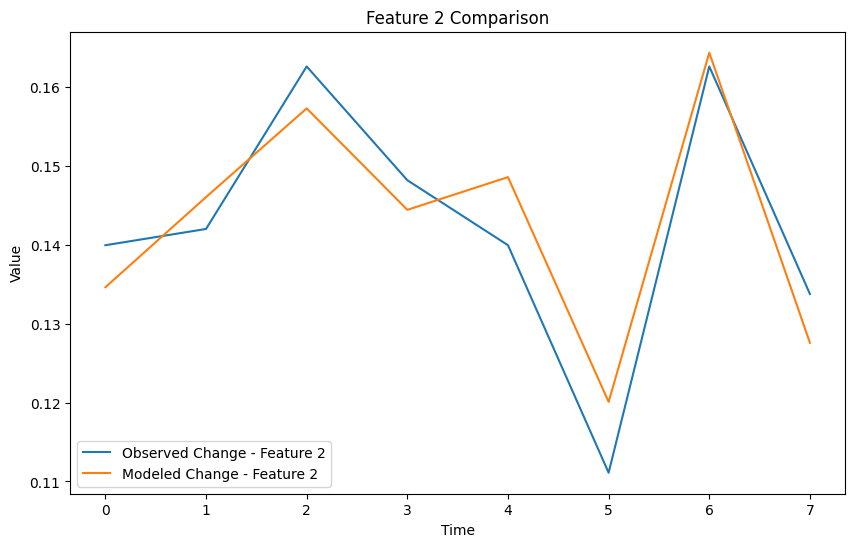

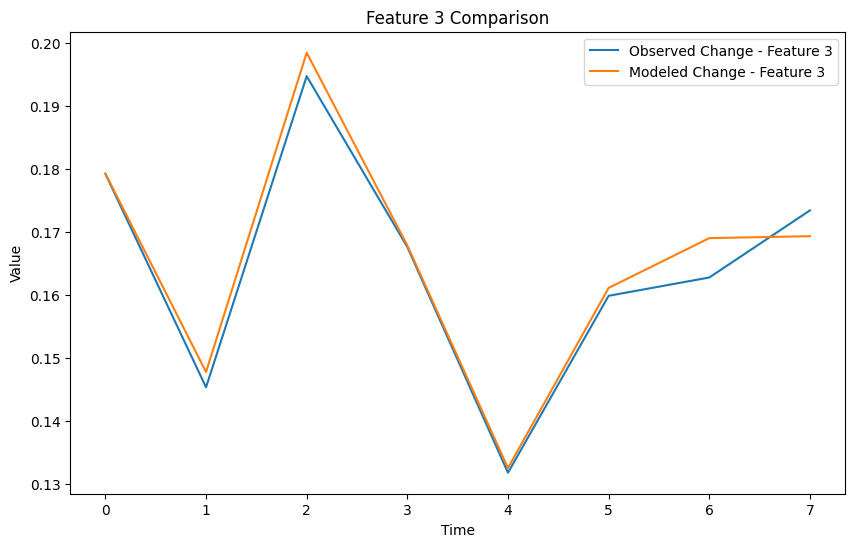

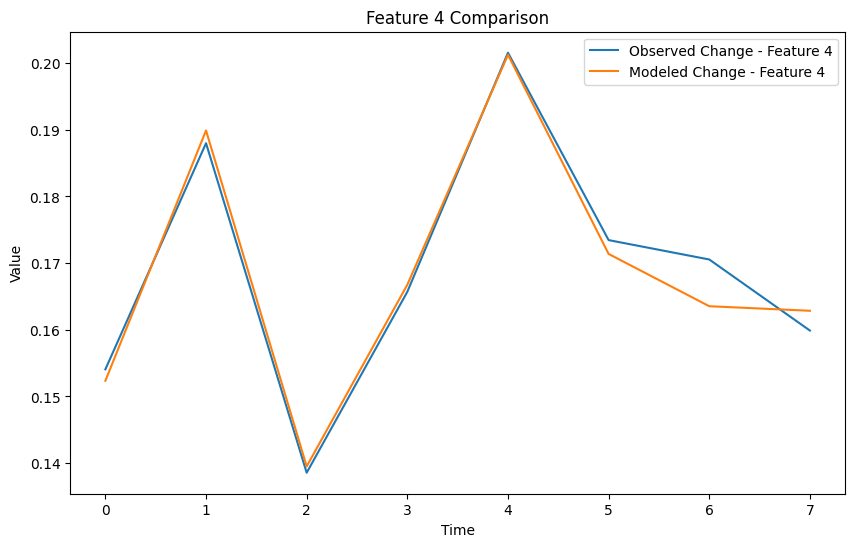

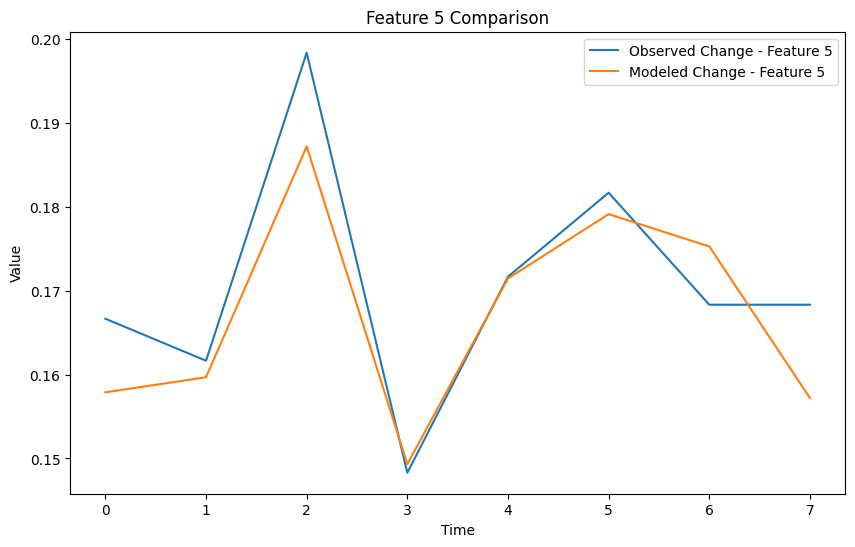

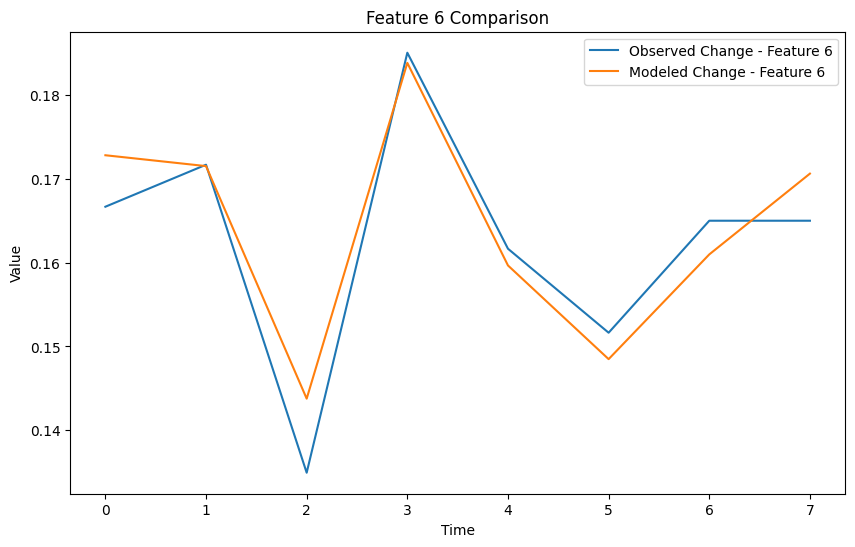

In [19]:
# Intialize Response Generator
generator = ResponseGenerator(cerberus_noforesight, preparer2.sliced_data, feature_indexes, preparer.max_change_dfs, preparer.conserved_subgroups)

# Generate a response for a specific index
sel_index = 761
generator.generate_response(sel_index)

generator.plot_normalized_responses()

### Unscaled Response Review

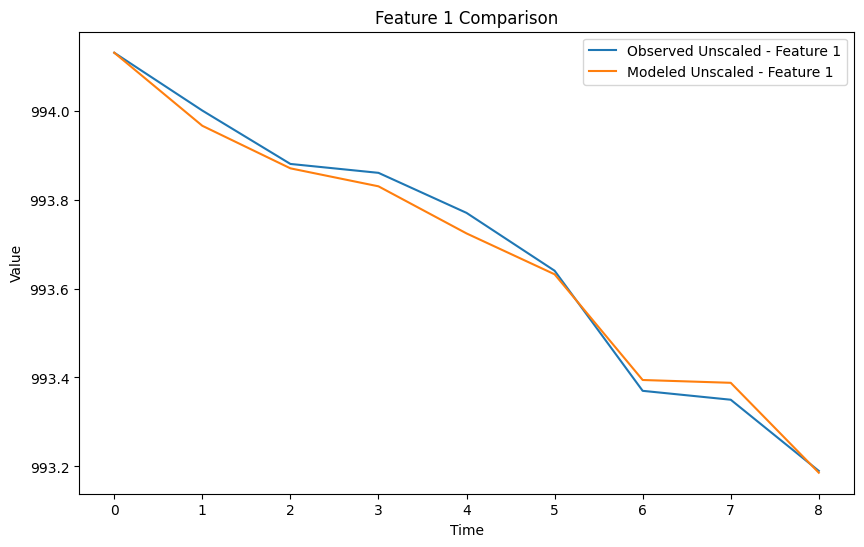

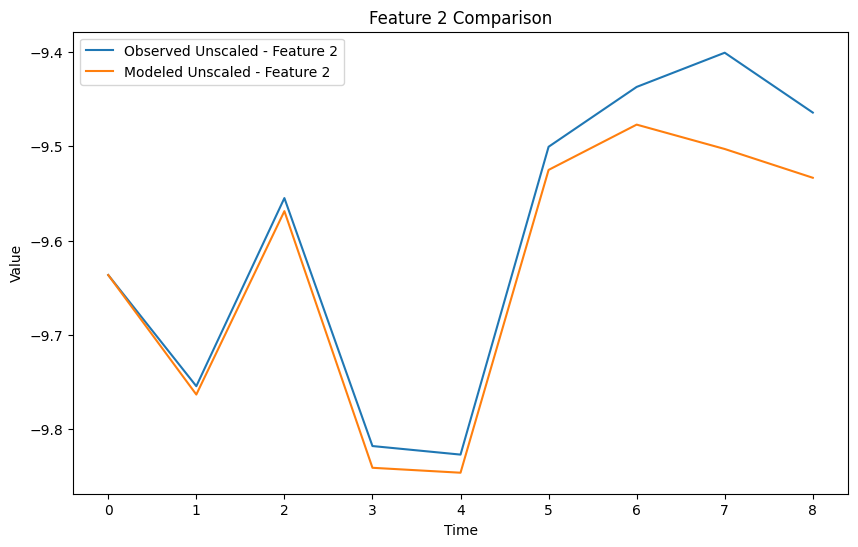

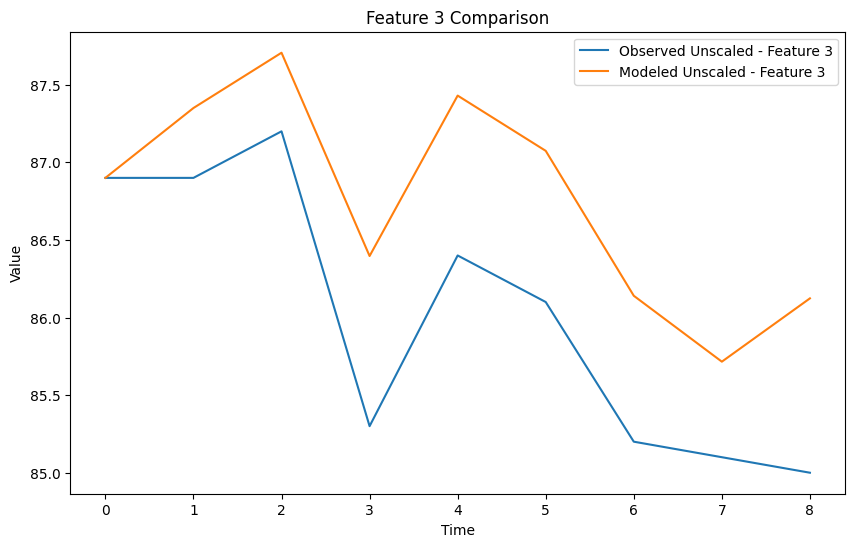

In [20]:
generator.plot_unscaled_responses(preparer.min_max_df, feature_indexes)

In [15]:
def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(cerberus_noforesight)

195723